# Comparing Ideal and NUI Synthesized Beams
## JCH - Feb. 2024

In [1]:
%config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


import importlib
import healpy as hp
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np


#### QUBIC IMPORT
from qubic.lib.Instrument import Qinstrument
from qubic.lib import Qdictionary 
from qubic.lib import Qscene
from qubic.lib.Qutilities import progress_bar



plt.rc('figure',figsize=(20,10))
plt.rc('font',size=15)




### QUBIC Instrument instanciation
ns = 1024
d = Qdictionary.qubicDict()
# dictfilename = 'pipeline_demo.dict'
d.read_from_file('/Users/hamilton/Python/GitQubicMousset/qubic/qubic/dicts/global_source_oneDet.dict')
d['nside']=ns
q = Qinstrument.QubicInstrument(d)
s = Qscene.QubicScene(d)

## Ideal Synthesized beam
There is a direct function to get the synthesized beam in the QUBIC library: `get_synthbeam()` from the class `QubicInstrument`.

(12582912,)


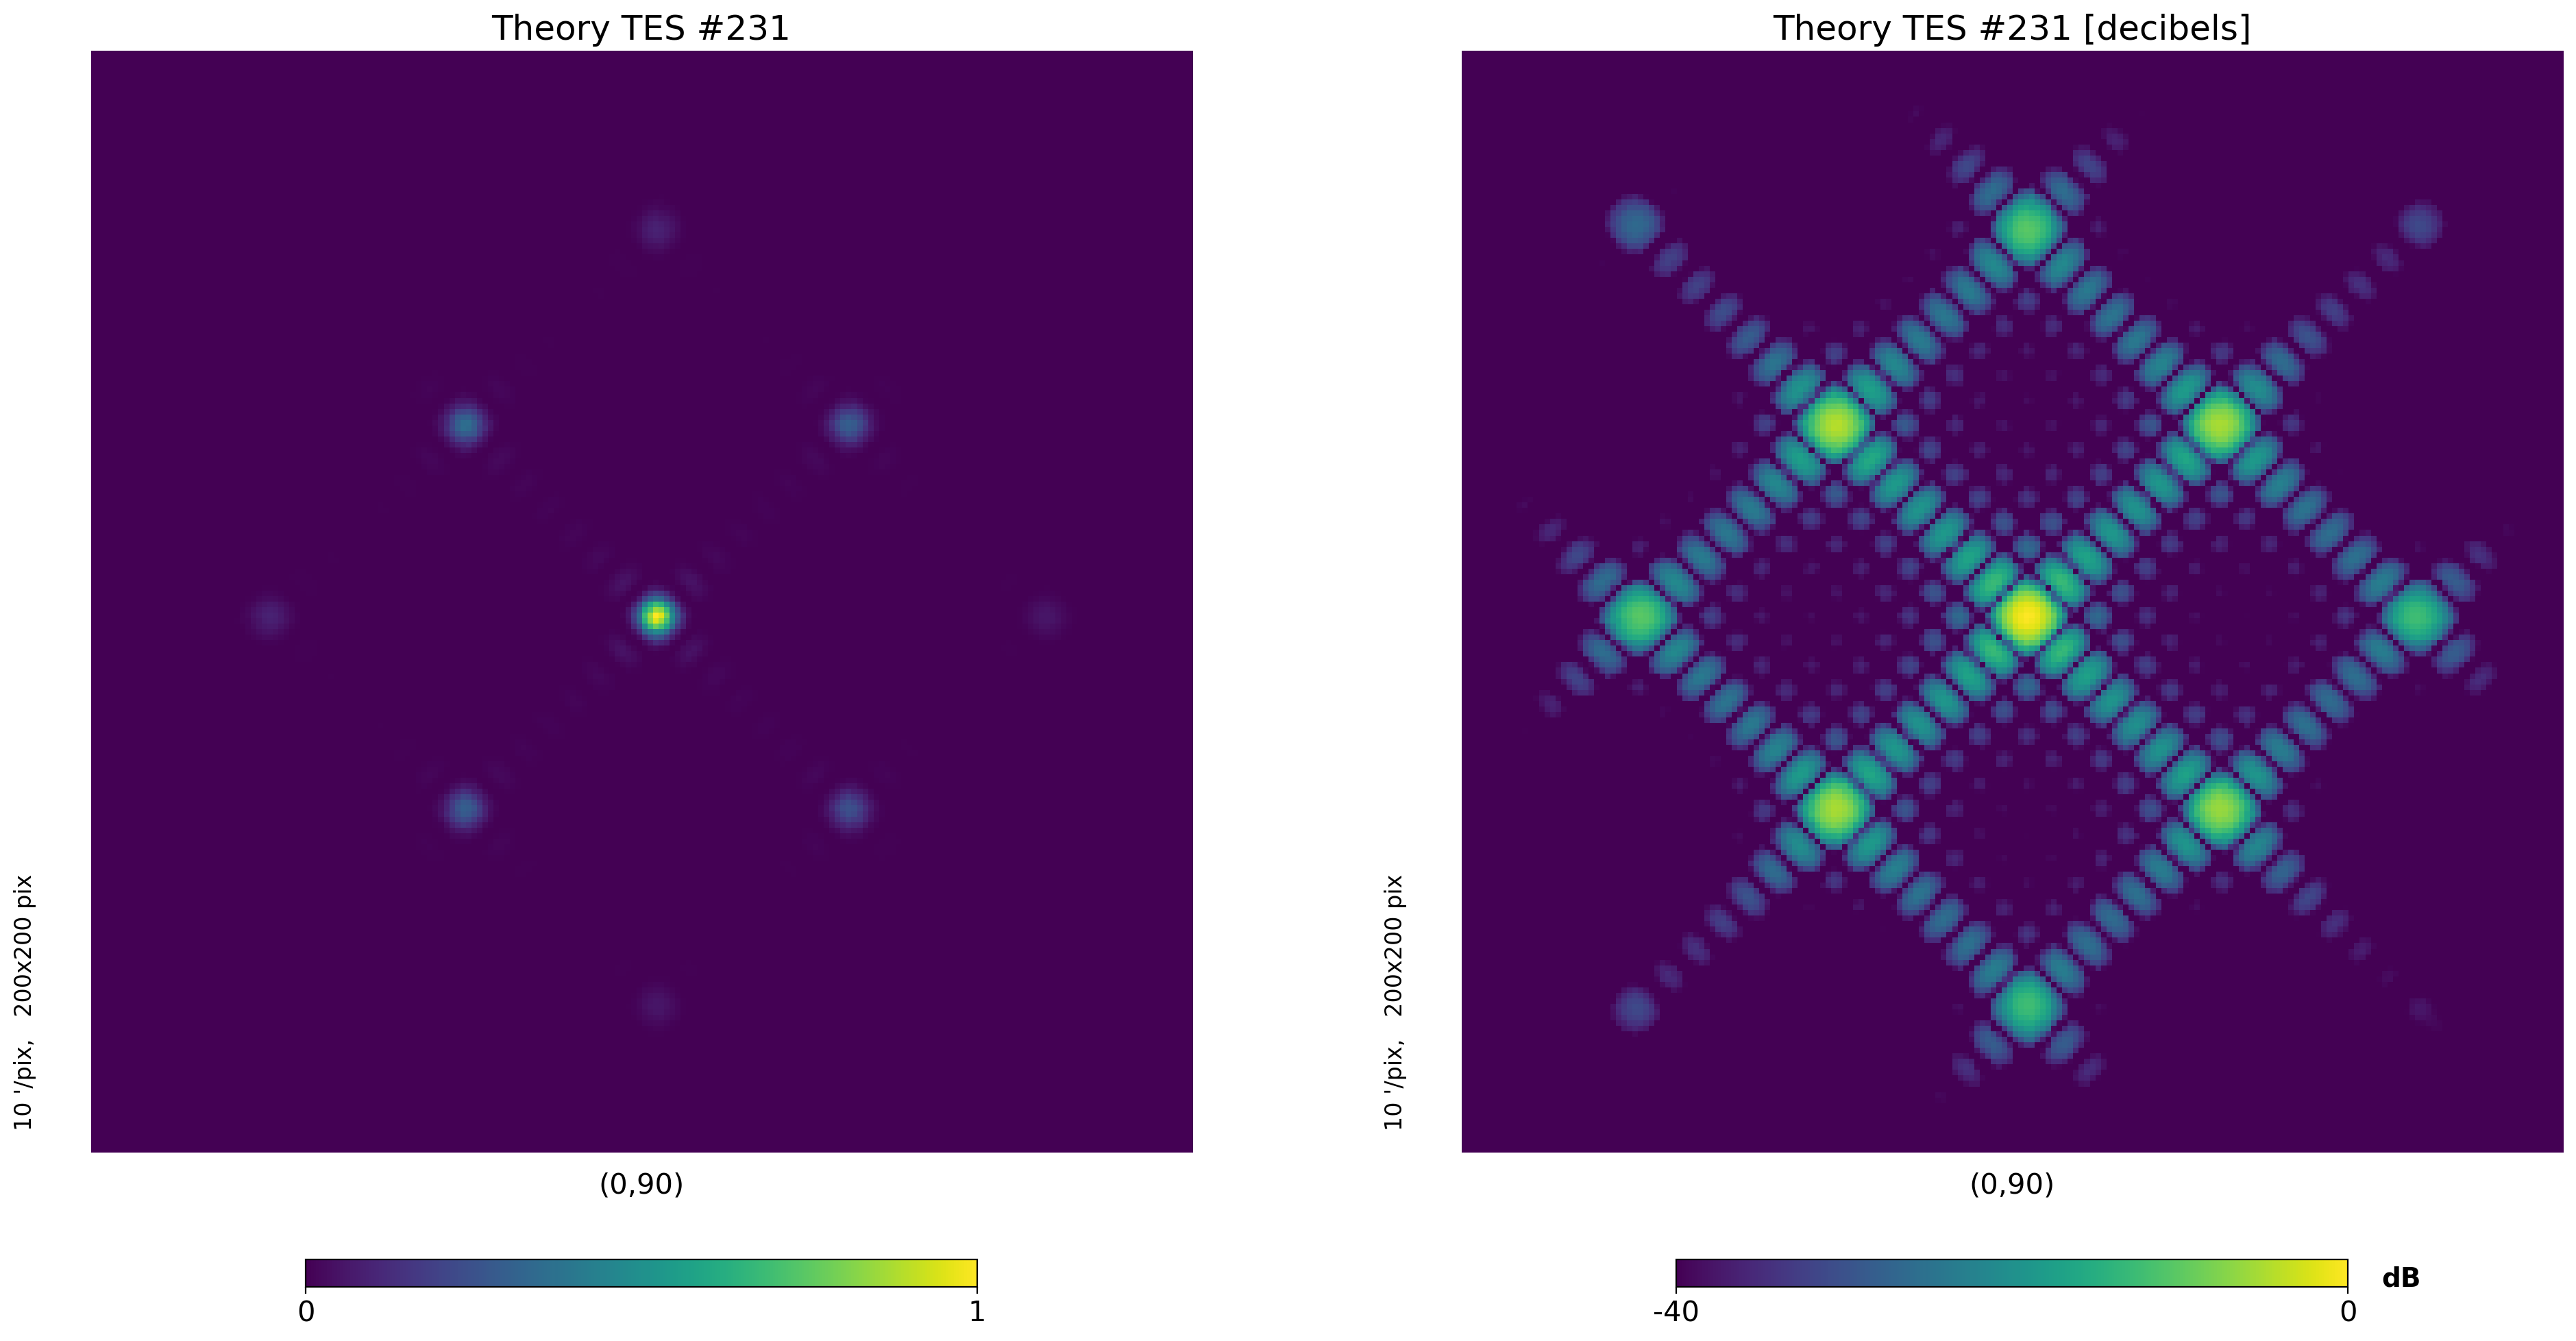

In [2]:
# idet = 64 ### This detector is on the edge of the focal plane
idet = 231 ### This detector is near the center of the focal plane
sb = q.get_synthbeam(s,idet)
hp.gnomview(sb/np.max(sb), rot=[0,90], reso=10, min=0, max=1,sub=(1,2,1), title='Theory TES #{}'.format(idet))
hp.gnomview(10*np.log10(sb/np.max(sb)), rot=[0,90], reso=10, min=-40, max=0, unit='dB',sub=(1,2,2), title='Theory TES #{} [decibels]'.format(idet))
print(np.shape(sb))

## Beam from NUI calculations
We have files with the phase and amplitude on the focal plane originating from each horn. They are obtained using Physical Optics simulations by Maynooth team (rather odl files... maybe there are more recent ones).



(25921, 4)


100%[=================================================================================================================================================================================================================]Time: 0:00:01


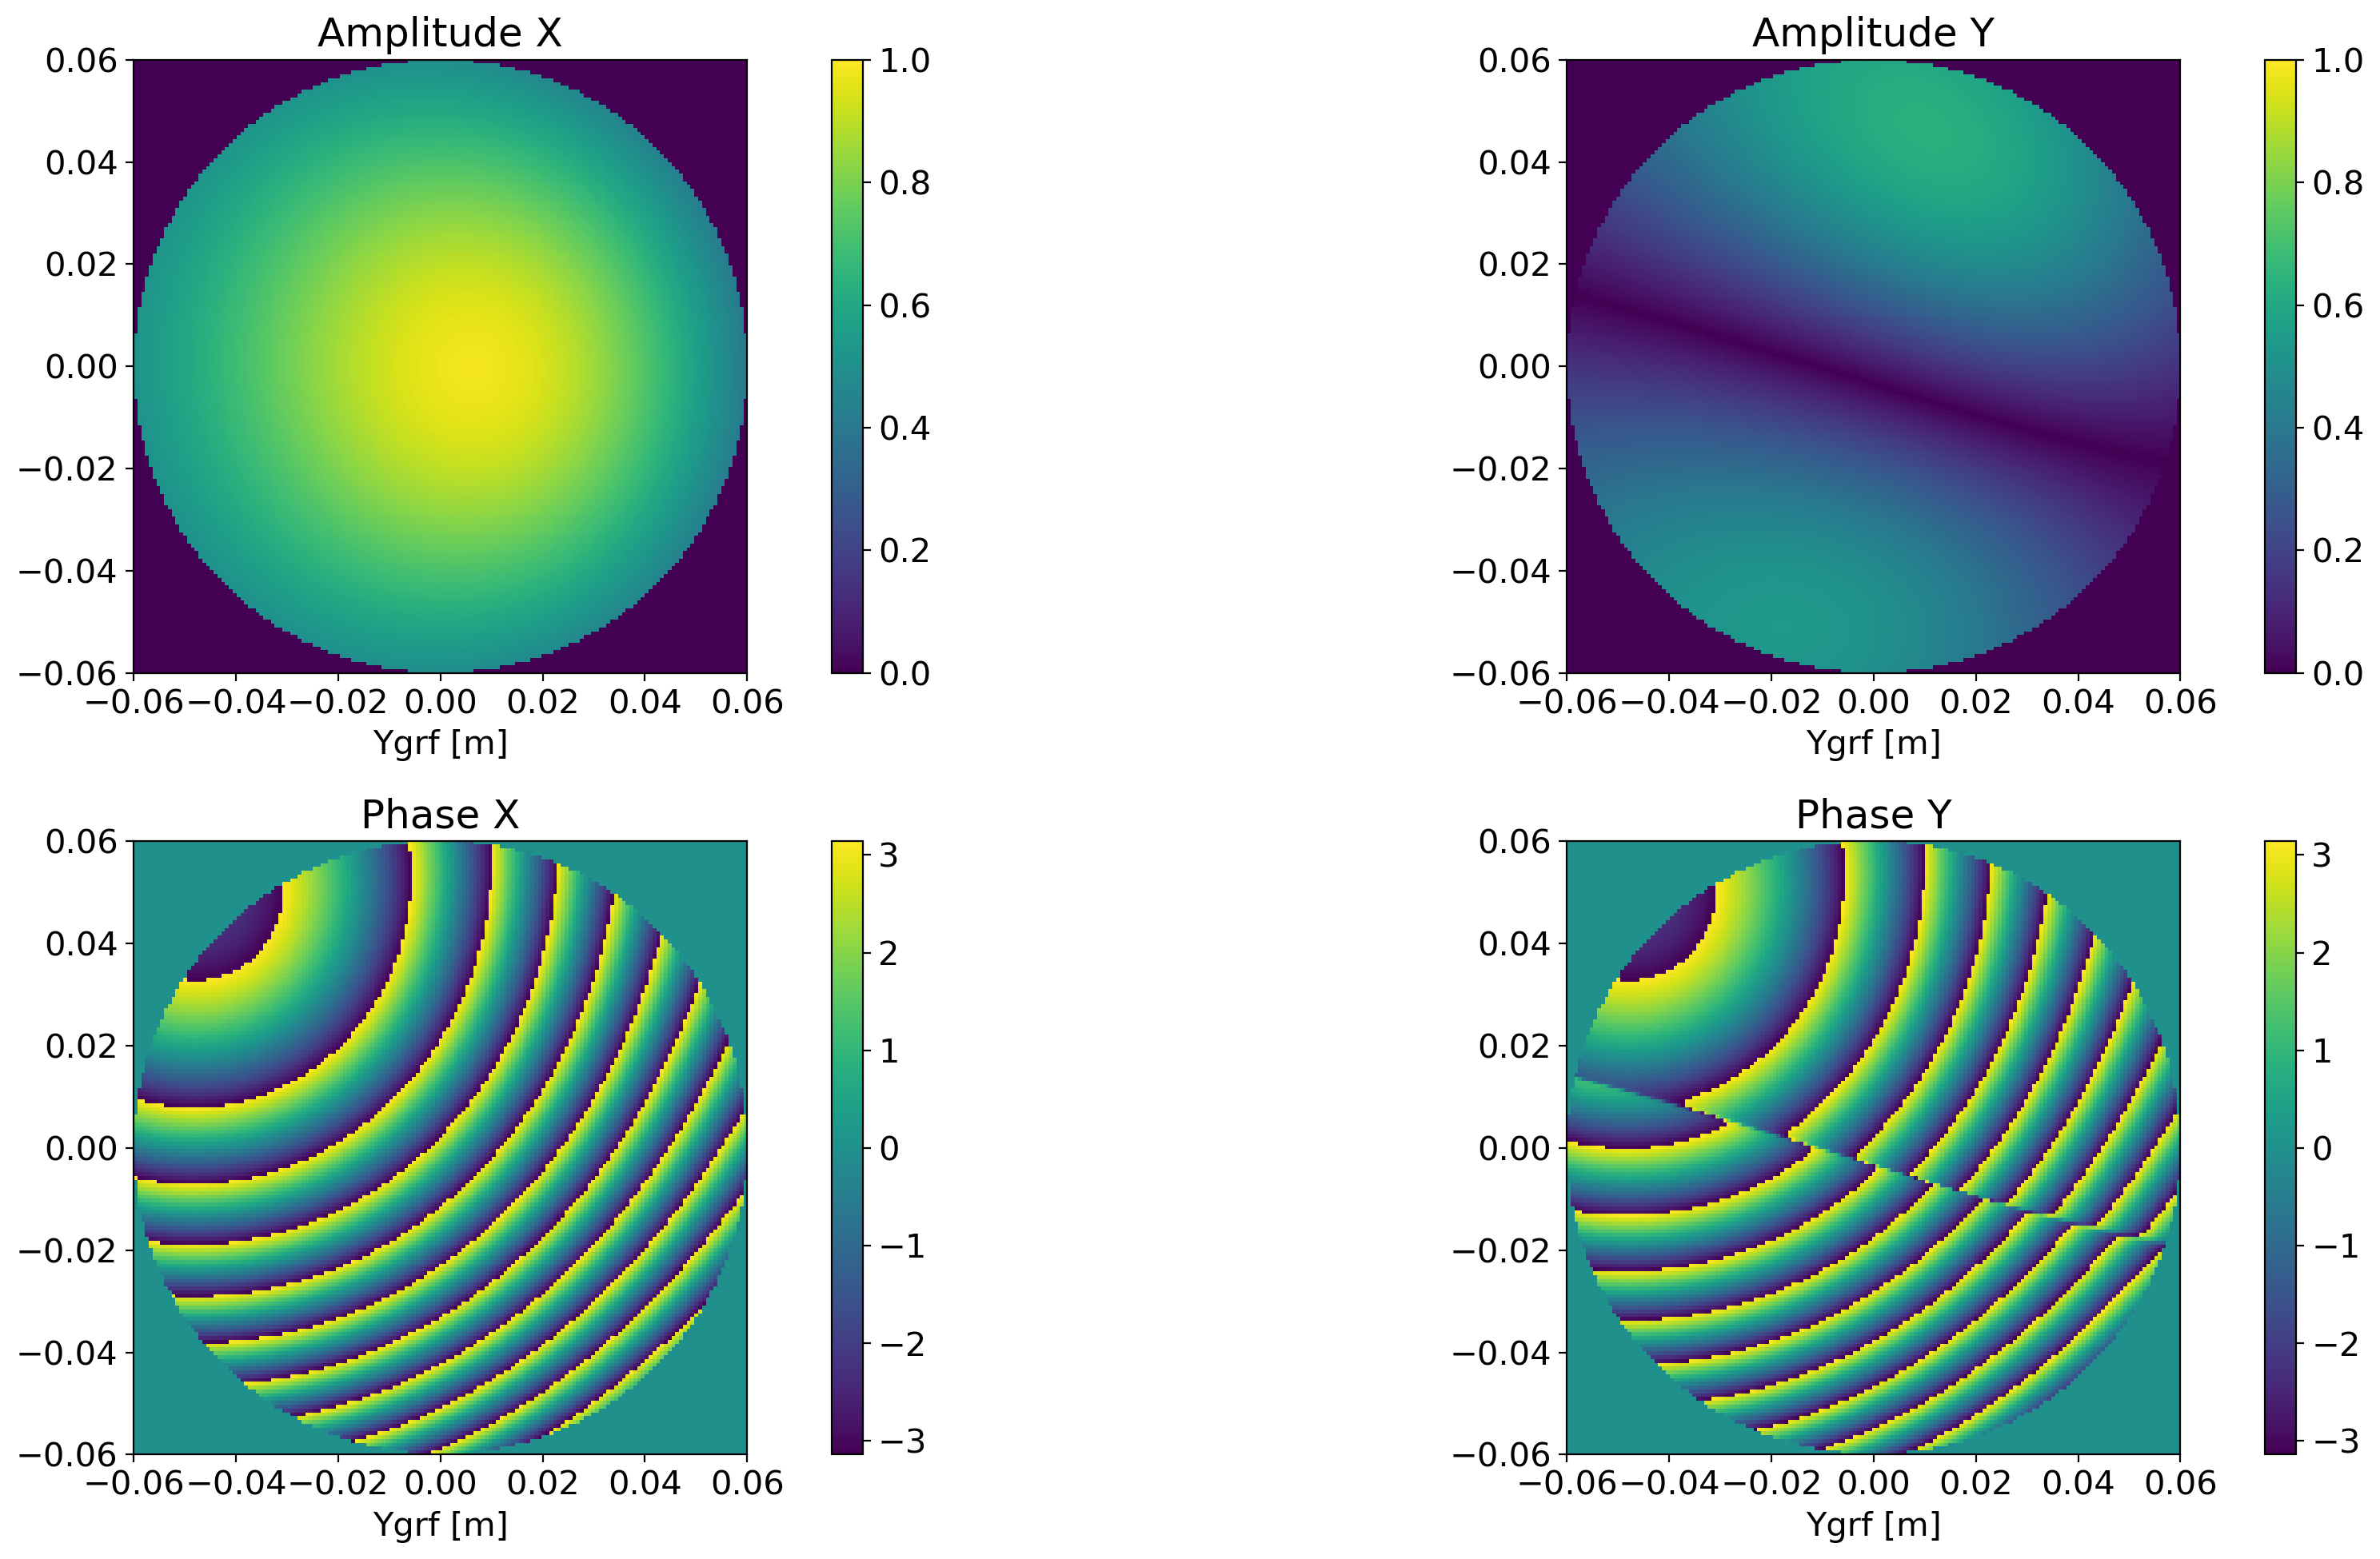

In [3]:

import glob
rep = '/Users/hamilton/Qubic/SynthBeam/NewSimsMaynooth/QUBIC Basic/'
files = glob.glob(rep+'*.dat')

nn = 161
xmin = -60./1000
xmax = 60./1000
ymin = -60./1000
ymax = 60./1000
xx = np.linspace(-60,60,nn)/1000
yy = np.linspace(-60,60,nn)/1000
nbhorns = len(q.horn)
allampX = np.zeros((nbhorns,nn,nn))
allphiX = np.zeros((nbhorns,nn,nn))
allampY = np.zeros((nbhorns,nn,nn))
allphiY = np.zeros((nbhorns,nn,nn))
#### Read the files
bar = progress_bar(nbhorns)
for i in range(nbhorns):
    bar.update()
    data = np.loadtxt(rep+'x{0:02d}y{1:02d}.dat'.format(q.horn.row[i]-1, q.horn.column[i]-1), skiprows=4)
    if i==0:
        print(np.shape(data))
    allampX[i,:,:] = np.reshape(data[:,0],(nn,nn))
    allphiX[i,:,:] = np.reshape(data[:,1],(nn,nn))
    allampY[i,:,:] = np.reshape(data[:,2],(nn,nn))
    allphiY[i,:,:] = np.reshape(data[:,3],(nn,nn))
external_A = [xx, yy, allampX, allampY, allphiX, allphiY]

horn_num = 0
plt.subplot(2,2,1)
plt.imshow(allampX[horn_num,:,:], 
       extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)], 
       origin='lower', vmin=0, vmax=1)
plt.xlabel('Xgrf [m]')
plt.xlabel('Ygrf [m]')
plt.title('Amplitude X')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(allampY[horn_num,:,:], 
       extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)], 
       origin='lower', vmin=0, vmax=1)
plt.xlabel('Xgrf [m]')
plt.xlabel('Ygrf [m]')
plt.title('Amplitude Y')
plt.colorbar()


plt.subplot(2,2,3)
plt.imshow(allphiX[horn_num,:,:], 
       extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)], 
       origin='lower', vmin=-np.pi, vmax=np.pi)
plt.xlabel('Xgrf [m]')
plt.xlabel('Ygrf [m]')
plt.title('Phase X')
plt.colorbar()


plt.subplot(2,2,4)
plt.imshow(allphiY[horn_num,:,:], 
       extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)], 
       origin='lower', vmin=-np.pi, vmax=np.pi)
plt.xlabel('Xgrf [m]')
plt.xlabel('Ygrf [m]')
plt.title('Phase Y')
plt.colorbar()

plt.tight_layout()

We use the same `get_synthbeam()` function, but adding the `external_A` data from Maynooth.

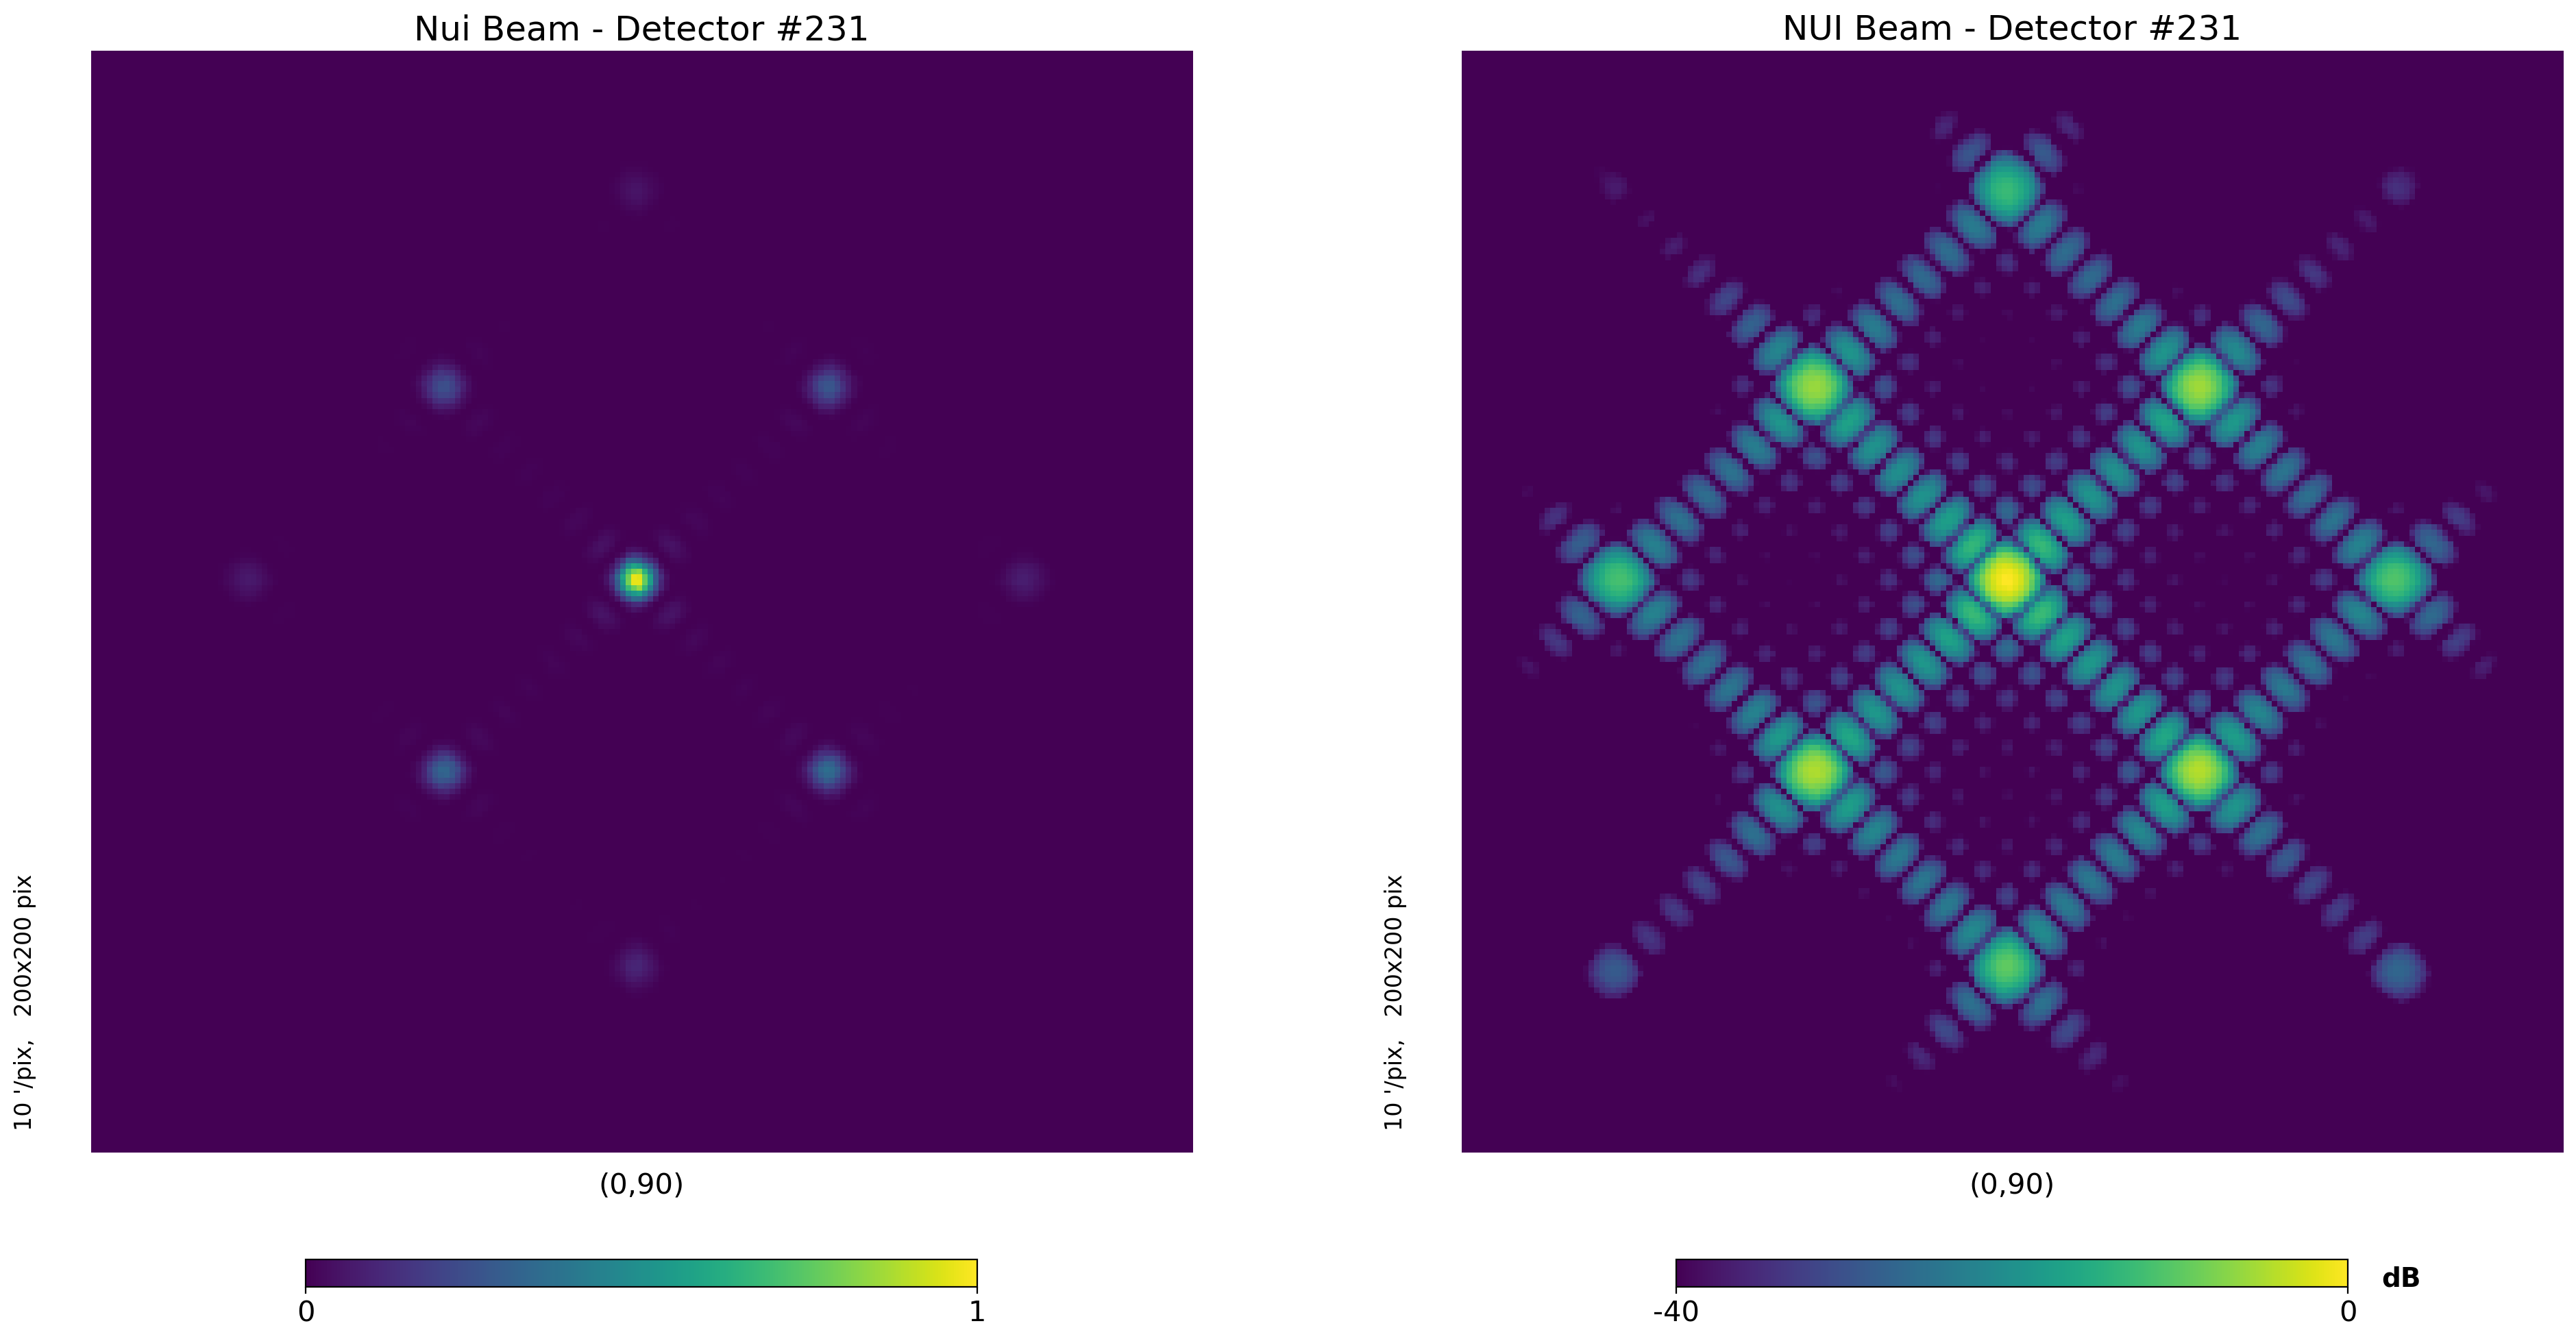

In [4]:

sb_nui = q.get_synthbeam(s, idet, external_A=external_A)
plt.figure()
hp.gnomview(sb_nui/np.max(sb_nui), rot=[0,90], 
        reso=10, min=0, max=1, title='Nui Beam - Detector #{}'.format(idet), sub=(1,2,1))
hp.gnomview(10*np.log10(sb_nui/np.max(sb_nui)), rot=[0,90], 
        reso=10, min=-40, max=0, unit='dB', title='NUI Beam - Detector #{}'.format(idet), sub=(1,2,2))


## Comparing Window functions

(0.0, 1.5)

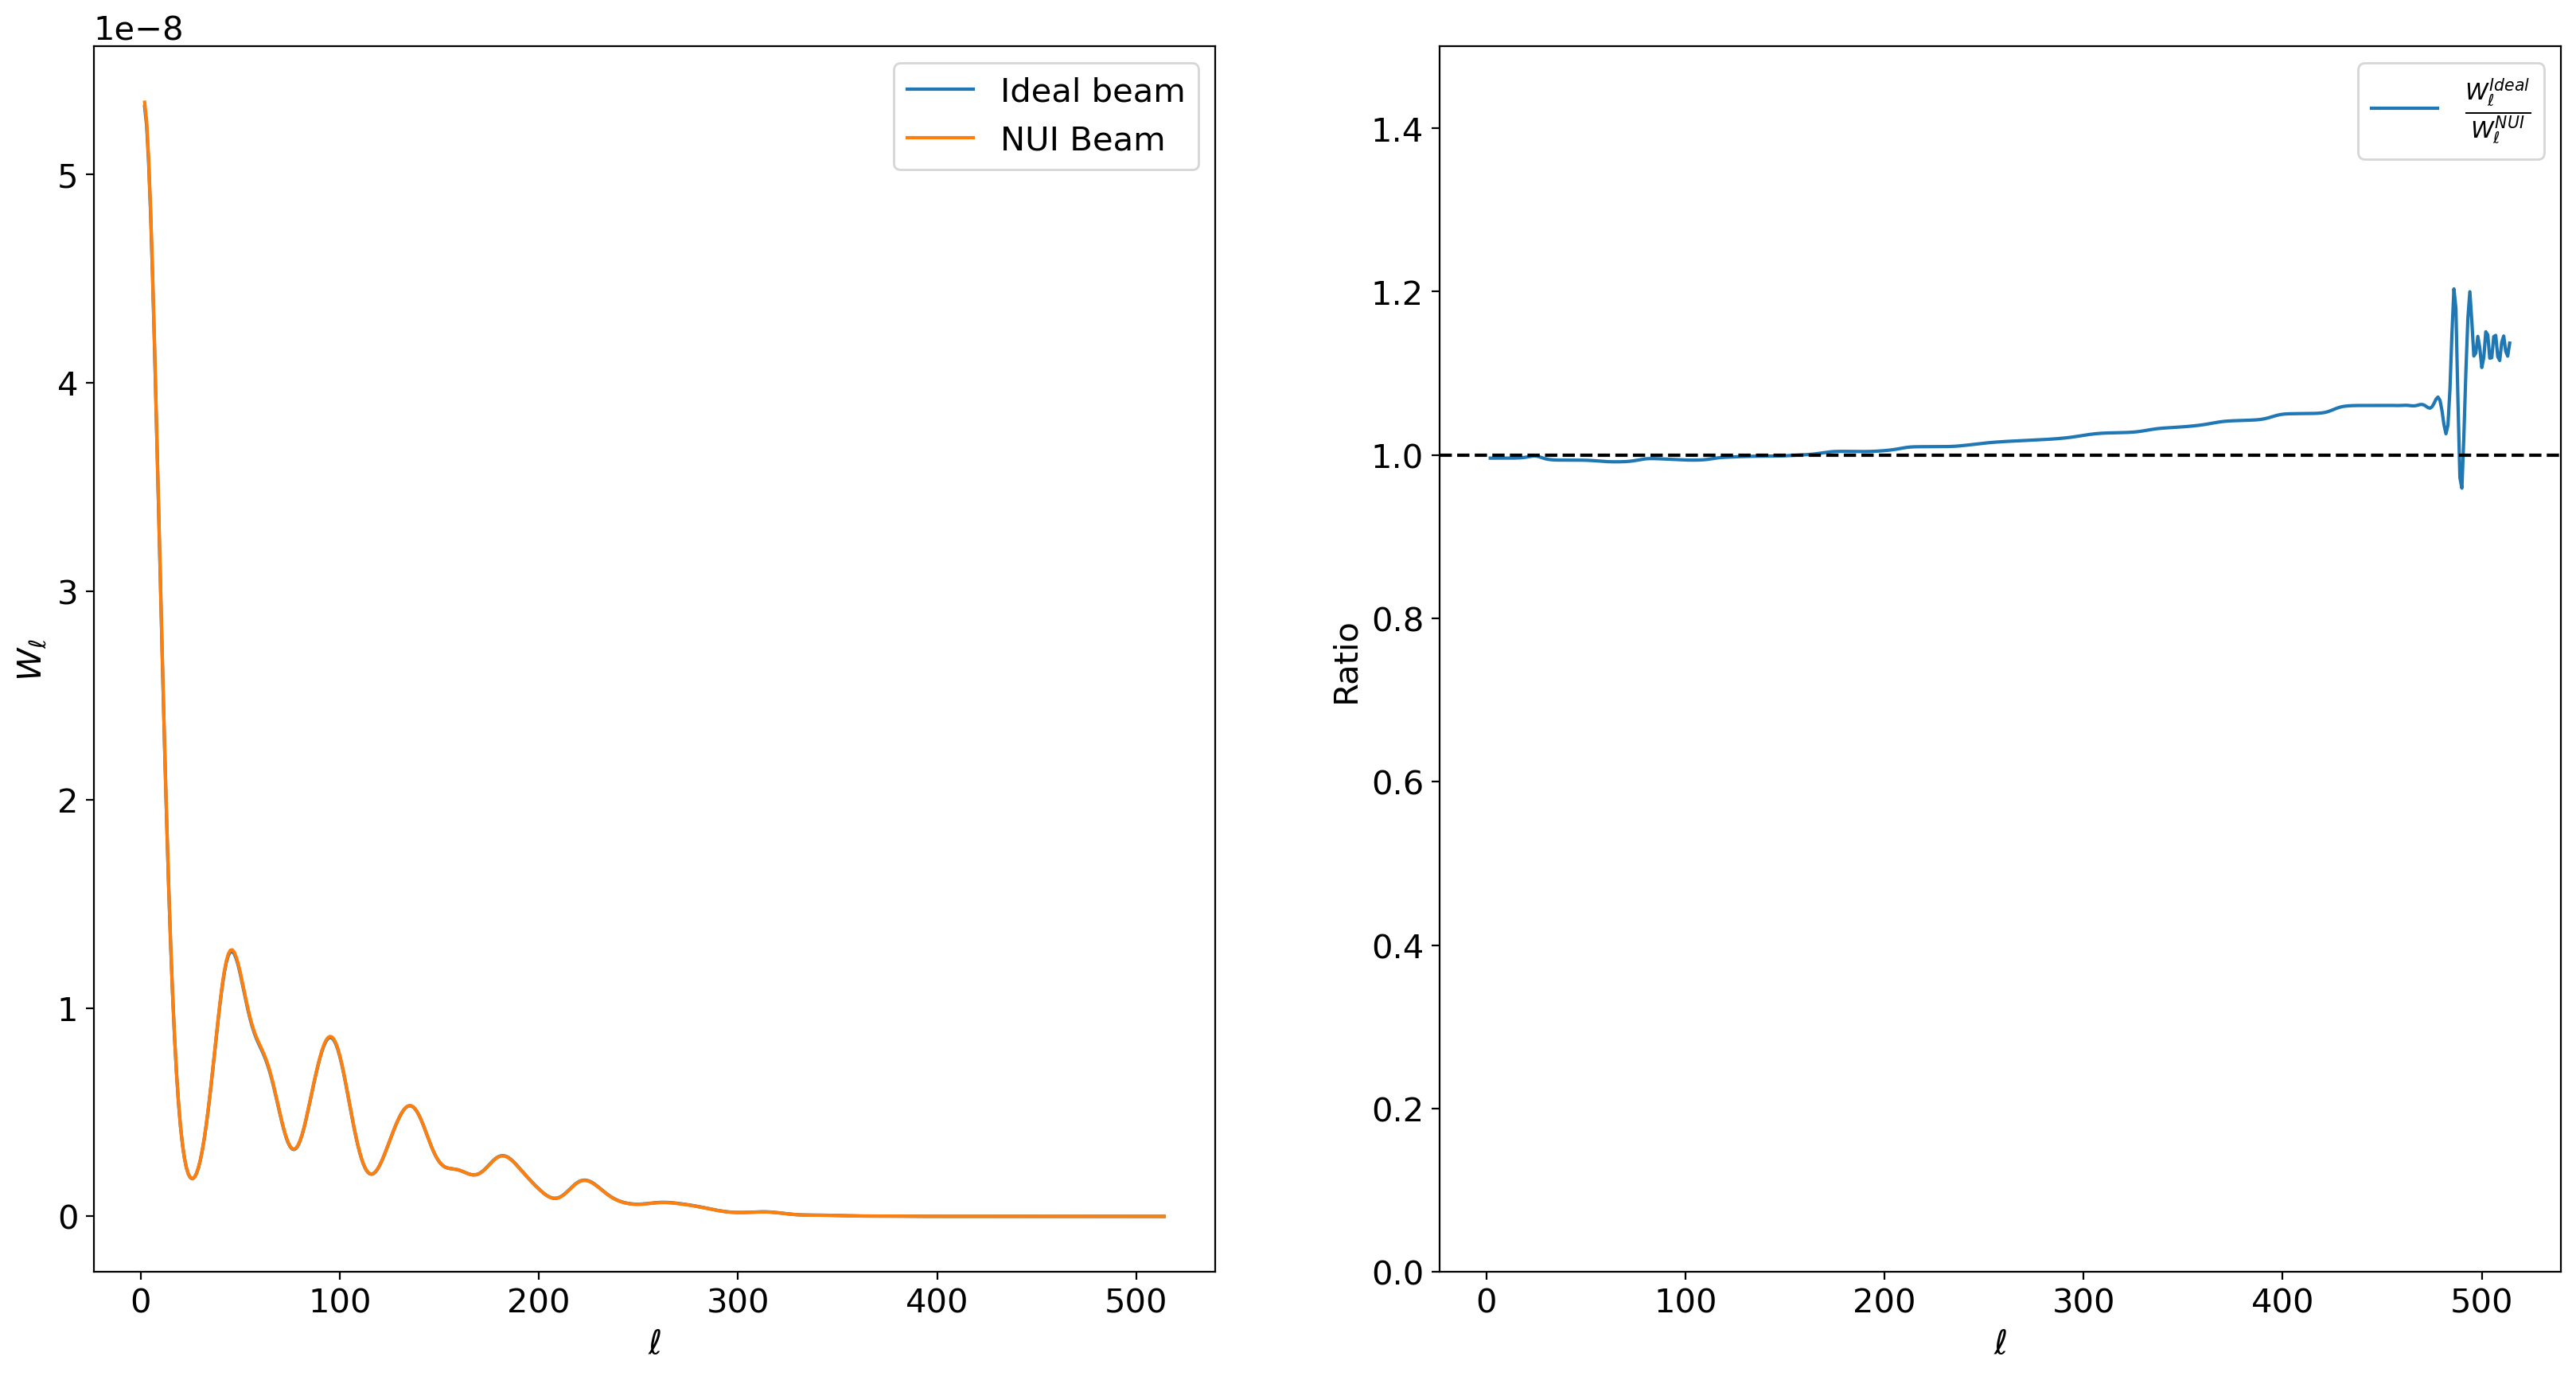

In [5]:
wf = hp.anafast(sb/np.max(sb), lmax=512)
wf_nui = hp.anafast(sb_nui / np.max(sb_nui), lmax=512)
ell = np.arange(len(wf))+2

plt.subplot(1,2,1)
plt.plot(ell, wf, label='Ideal beam')
plt.plot(ell, wf_nui, label='NUI Beam')
#plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$W_\ell$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ell, wf/wf_nui, label=r'$\frac{W_\ell^{Ideal}}{W_\ell^{NUI}}$')
plt.xlabel('$\ell$')
plt.ylabel('Ratio')
plt.axhline(y=1, color='k', ls='--')
plt.legend()
plt.ylim(0,1.5)